<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Absorption_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 2.1 MB/s 


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import csv
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare, chi2
from sklearn.metrics import mean_squared_error

def fit(x, b, l):
  return b*np.exp(-x/l)

def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

# Influence of Projection

To generate random $(\theta, \phi)$ coordinates on a spherical cap with and aperture angle, $\alpha$, with two unimform random numbers $r_1,r_2 \in [0,1]$, we define:

$$\theta=2π \times r_1$$
$$\phi = \arccos[(1−\cos\alpha)\times r_2+\cos\alpha] $$

Reference: https://math.stackexchange.com/questions/2076415/points-on-surface-of-spherical-cap

The radius of each point, $\rho$, is given by the distance travelled in the medium, $d$, which depends on the absorption length, $\lambda$: 

$$A = \exp(-d/\lambda)$$

and is calculated from a third random number, $r_3$:

$$\rho = - \lambda \ln(r_3)$$

From this, the $(x,y,z)$ coordinates where calculated, as well as the real distance between each point and the source, $d=\sqrt{x^2+ y^2+z^2}$, as well as the projection of the point, $p=\sqrt{x^2+ y^2}$ (without considering the $z$-coordinate).

The real distances, $d$, and projections, $p$, are then histogramed and fitted to equation $f(x)=b\times \exp(-x/\lambda)$, to validate the true $\lambda$ generation, and determine the effective $\lambda$, respectively.

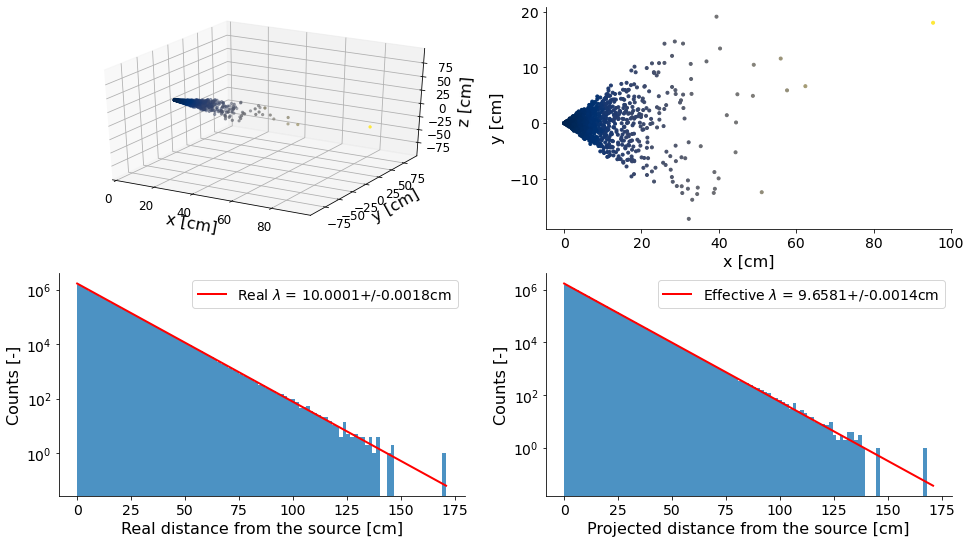

In [ ]:
#@title Single $\lambda$ visualization

#@markdown In this cell, we can visualise and calculate the effective 
#@markdown $\lambda$ distribution for a given aperture and $\lambda$.

def single_lambda(real_lambda, degree):
  runs = 10000000
  aperture = degree* np.pi/180
  theta = np.random.uniform(low=0, high=2*np.pi, size= runs)
  phi = np.arccos((1-np.cos(aperture)) * np.random.uniform(low=0, high=1, size= runs) + np.cos(aperture))
  rho = -real_lambda * np.log(np.random.uniform(low=0, high=1, size= runs))
  z = rho * np.cos(theta) * np.sin(phi)
  y = rho * np.sin(theta) * np.sin(phi)
  x = rho * np.cos(phi)
  proj = np.sqrt(x**2 + y**2)
  d = np.sqrt(x**2 + y**2 + z**2)

  fig = plt.figure(figsize=(16, 9))

  ax1 = fig.add_subplot(2, 2, 1, projection='3d')
  ax1.scatter3D(x[:1000], y[:1000], z[:1000], c=d[:1000], marker='.', cmap='cividis')
  ax1.set_xlim(0,np.max(d[:1000]))
  ax1.set_ylim(-np.max(d[:1000]),np.max(d[:1000]))
  ax1.set_zlim(-np.max(d[:1000]),np.max(d[:1000]))
  ax1.set_xlabel('x [cm]', fontsize=16)
  ax1.set_ylabel('y [cm]', fontsize=16)
  ax1.set_zlabel('z [cm]', fontsize=16)
  ax1.tick_params(axis='both', which='major', labelsize=12)

  ax2 = fig.add_subplot(2, 2, 2)
  ax2.scatter(x[:1000],y[:1000], c=d[:1000], marker='.', cmap='cividis')
  ax2.set_xlabel('x [cm]', fontsize=16)
  ax2.set_ylabel('y [cm]', fontsize=16)
  ax2.tick_params(axis='both', which='major', labelsize=14)
  ax2.spines["right"].set_visible(False)
  ax2.spines["top"].set_visible(False)
  
  ax3 = fig.add_subplot(2, 2, 3)
  x = np.arange(0,np.max(d), 0.01)
  n, bins, patches =  ax3.hist(d, bins=100, align='mid', color='tab:blue', alpha=0.8)
  bin_middles = (bins[1:]+bins[:-1])/2
  popt, pcov = curve_fit(fit, bin_middles, n, p0=[1e6, 10])
  pcov = np.sqrt(np.diag(pcov))
  ycalc = fit(x, *popt)
  ax3.plot(x,ycalc, color='r', lw=2, label='Real $\lambda$ = '+str(ufloat(popt[1], pcov[1]))+'cm')
  ax3.semilogy()
  ax3.legend(fontsize=14)
  ax3.set_xlabel('Real distance from the source [cm]', fontsize=16)
  ax3.set_ylabel('Counts [-]', fontsize=16)
  ax3.tick_params(axis='both', which='major', labelsize=14)
  ax3.spines["right"].set_visible(False)
  ax3.spines["top"].set_visible(False)

  ax4 = fig.add_subplot(2, 2, 4)
  n, bins, patches =  ax4.hist(proj, bins=100, align='mid', color='tab:blue', alpha=0.8)
  bin_middles = (bins[1:]+bins[:-1])/2
  popt, pcov = curve_fit(fit, bin_middles, n, p0=[10000, 1])
  pcov = np.sqrt(np.diag(pcov))
  ycalc = fit(x, *popt)
  ax4.plot(x,ycalc, color='r', lw=2, label='Effective $\lambda$ = '+str(ufloat(popt[1], pcov[1]))+'cm')
  ax4.semilogy()
  ax4.legend(fontsize=14)
  ax4.set_xlabel('Projected distance from the source [cm]', fontsize=16)
  ax4.set_ylabel('Counts [-]', fontsize=16)
  ax4.tick_params(axis='both', which='major', labelsize=14)
  ax4.spines["right"].set_visible(False)
  ax4.spines["top"].set_visible(False)

  plt.show

Absorption_length =  10#@param {type:"raw"}

Aperture =  30#@param {type:"raw"}

single_lambda(Absorption_length, Aperture)

In [ ]:
#@title Get file for different $\lambda$s and apertures

#@markdown In this cell, we can generate a .csv file with effective $\lambda$s for an array of different apertures and $\lambda$s.

#@markdown No visualisation is given for the sake of speed.

# open the file in the write mode
f = open('/content/drive/MyDrive/LIME/effective_lambda.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(['Aperture [º]', 'Input Lambda', 'Real Lambda', 'uReal Lambda', 'Effective Lambda', 'uEffective Lambda'])

for real_lambda in [43.91, 83.04, 192.68, 527.10, 3394.46]:
  for degree in [5,10,15,20,25,30,35,40,45]:
    runs = 100000000
    aperture = degree* np.pi/180
    theta = np.random.uniform(low=0, high=2*np.pi, size= runs)
    phi = np.arccos((1-np.cos(aperture)) * np.random.uniform(low=0, high=1, size= runs) + np.cos(aperture))
    rho = -real_lambda * np.log(np.random.uniform(low=0, high=1, size= runs))
    z = rho * np.cos(theta) * np.sin(phi)
    y = rho * np.sin(theta) * np.sin(phi)
    x = rho * np.cos(phi)
    proj = np.sqrt(x**2 + y**2)
    d = np.sqrt(x**2 + y**2 + z**2)

    hist, bins = np.histogram(d, bins=100)
    bins = (bins[1:]+bins[:-1])/2
    popt, pcov = curve_fit(fit, bins, hist, p0=[1e6, 1000])
    pcov = np.sqrt(np.diag(pcov))
    true = ufloat(popt[1], pcov[1])

    hist, bins = np.histogram(proj, bins=100)
    bins = (bins[1:]+bins[:-1])/2
    popt, pcov = curve_fit(fit, bins, hist, p0=[1e6, 1000])
    pcov = np.sqrt(np.diag(pcov))
    effective = ufloat(popt[1], pcov[1])
    writer.writerow([degree, real_lambda, true.n, true.s, effective.n, effective.s])

# close the file
f.close()

In [ ]:
#@title Load the results file

results = pd.read_csv('/content/drive/MyDrive/LIME/effective_lambda.csv')
results.head()

,Aperture [º],Input Lambda,Real Lambda,uReal Lambda,Effective Lambda,uEffective Lambda
0,5,43.91,43.897661,0.001897,43.855491,0.001898
1,10,43.91,43.919504,0.003007,43.752334,0.002932
2,15,43.91,43.920357,0.003369,43.543743,0.003623
3,20,43.91,43.902422,0.002996,43.233845,0.003071
4,25,43.91,43.916798,0.002087,42.871434,0.002124


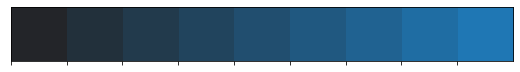

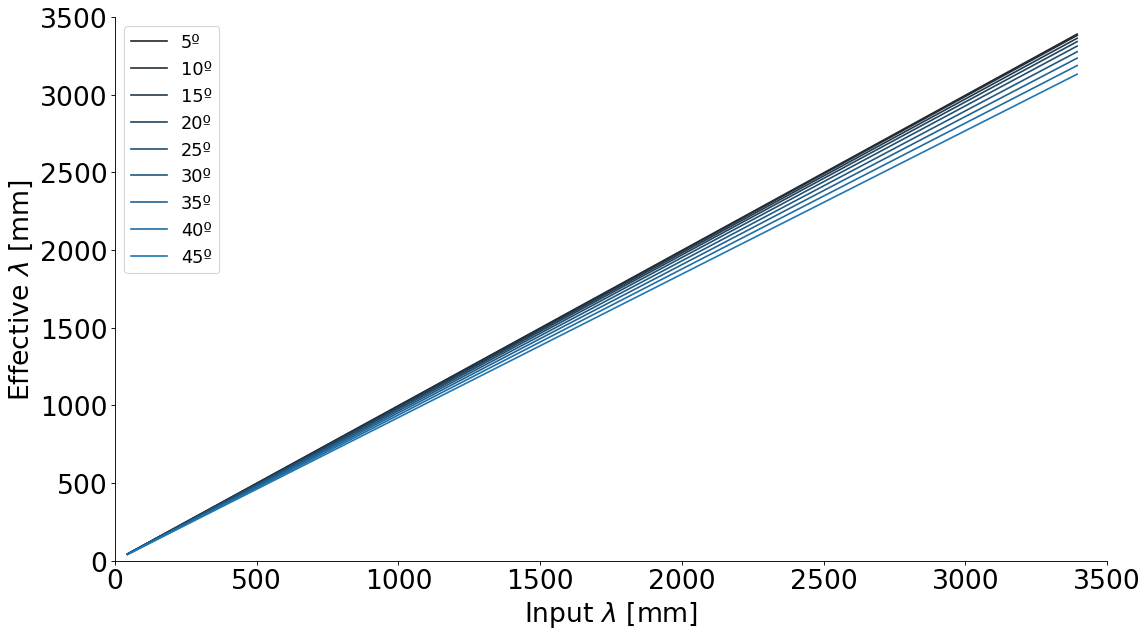

In [ ]:
#@title Effective $\lambda$ in function of the input $\lambda$, for different appertures
#@markdown As the aperture angle increases, the effective $\lambda$ decreases relatively to the input $\lambda$.
color = get_color(9, 'tab:blue')

fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 

i=0
for aperture in [5,10,15,20,25,30,35,40,45]:
  plt.plot(results['Input Lambda'].loc[results['Aperture [º]']==aperture], 
           results['Effective Lambda'].loc[results['Aperture [º]']==aperture],
           color=color[i], label=str(aperture)+'º')
  i=i+1

ax.set_xlabel('Input $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax.set_ylim(0, 3500)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Effective $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlim(0,3500)
plt.legend(fontsize=16)
plt.show()

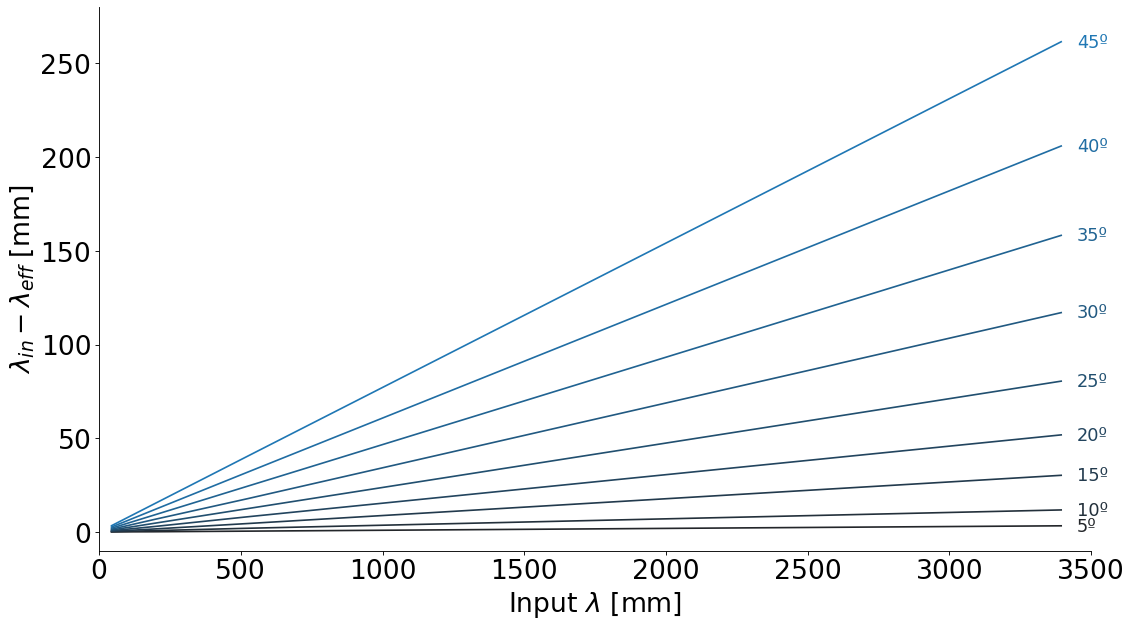

In [ ]:
#@title Difference between input and effective $\lambda$ in function of the input $\lambda$, for different appertures
##@markdown As the aperture angle increases, the the difference between the input and effective $\lambda$ increases.

results['Difference'] = results['Input Lambda']-results['Effective Lambda']
fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 

i=0
for aperture in [5,10,15,20,25,30,35,40,45]:
  plt.plot(results['Input Lambda'].loc[results['Aperture [º]']==aperture], 
           results['Difference'].loc[results['Aperture [º]']==aperture],
           color=color[i], label=str(aperture)+'º')
  plt.text(3450, results['Difference'].loc[results['Aperture [º]']==aperture].iloc[-1], 
           str(aperture)+'º', ha='left', fontsize=16, color=color[i], va='center')
  i=i+1

ax.set_xlabel('Input $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax.set_ylim(-10, 280)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('$\lambda_{in}-\lambda_{eff}$ [mm]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlim(0,3500)
#plt.legend(fontsize=16)
plt.show()

Mean relative error for 5 º:  0.102+/-0.019
Mean relative error for 10 º:  0.376+/-0.022
Mean relative error for 15 º:  0.853+/-0.025
Mean relative error for 20 º:  1.534+/-0.017
Mean relative error for 25 º:  2.383+/-0.015
Mean relative error for 30 º:  3.425+/-0.021
Mean relative error for 35 º:  4.6668+/-0.0030
Mean relative error for 40 º:  6.094+/-0.017
Mean relative error for 45 º:  7.714+/-0.008
a = 0.00381+/-0.00008
b =  -0.000+/-0.004
c =  0.00+/-0.06


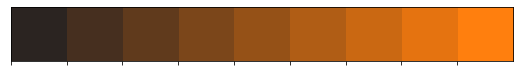

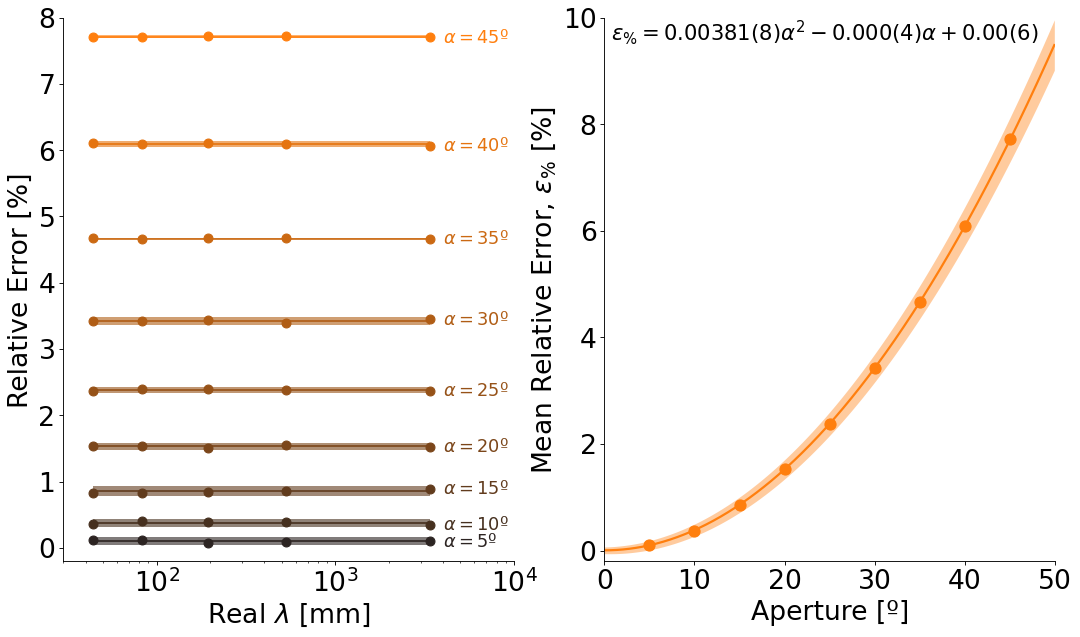

In [ ]:
#@title Relative error in the calculation of the effective $\lambda$ as a function of the input $\lambda$, for different appertures
##@markdown The relative error of the effective $\lambda$ only depends on the aperture of the source.
color = get_color(9, 'tab:orange')

results['Rel. Error'] = (results['Input Lambda']-results['Effective Lambda'])/results['Input Lambda']*100
fig, (ax) = plt.subplots(1,2, figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 

alpha = []
error = []
derror = []

i=0
for aperture in [5,10,15,20,25,30,35,40,45]:
  ax[0].plot(results['Input Lambda'].loc[results['Aperture [º]']==aperture], 
           results['Rel. Error'].loc[results['Aperture [º]']==aperture],
           color=color[i], label=str(aperture)+'º', marker='o', lw=0, markersize=8)
  ax[0].text(4e3, results['Rel. Error'].loc[results['Aperture [º]']==aperture].iloc[-1], 
           r'$\alpha=$'+str(aperture)+'º', ha='left', fontsize=16, color=color[i], va='center')
  ax[0].hlines(y=results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean(), xmin=43.91, xmax=3394.46, color=color[i])
  ax[0].fill_between(results['Input Lambda'].loc[results['Aperture [º]']==aperture],
                   results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean()-3*results['Rel. Error'].loc[results['Aperture [º]']==aperture].std(),
                   results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean()+3*results['Rel. Error'].loc[results['Aperture [º]']==aperture].std(),
                   color=color[i], lw=0, alpha=0.6)
  print('Mean relative error for', aperture, 'º: ', ufloat(results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean(), 
               results['Rel. Error'].loc[results['Aperture [º]']==aperture].std()))
  alpha.append(aperture)
  error.append(results['Rel. Error'].loc[results['Aperture [º]']==aperture].mean())
  derror.append(results['Rel. Error'].loc[results['Aperture [º]']==aperture].std())
  i=i+1

ax[0].set_xlabel('Real $\lambda$ [mm]', y=0.5, ha='center', fontsize=24)
ax[0].set_ylim(-0.2, 8)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].set_ylabel('Relative Error [%]', y=0.5, ha='center', fontsize=24)
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[0].tick_params(axis='both', which='minor', labelsize=24)
ax[0].set_xlim(30,1e4)
ax[0].semilogx()

ax[1].errorbar(alpha, error, yerr=derror, lw=0, marker='o', markersize=10, color='tab:orange')

def pol(x, a, b, c):
  return a*x**2+b*x+c

popt, pcov = curve_fit(pol, alpha, error, p0=[1,0.01, 1], absolute_sigma=True, sigma=derror)
ycalc =pol(np.arange(0, 50, 0.1), *popt)
pcov = np.sqrt(np.diag(pcov))
print('a =', ufloat(popt[0], 3*pcov[0]))
print('b = ', ufloat(popt[1], 3*pcov[1]))
print('c = ', ufloat(popt[2], 3*pcov[2]))

bound_upper = pol(np.arange(0, 50, 0.1), *(popt + 3*pcov))
bound_lower = pol(np.arange(0, 50, 0.1), *(popt - 3*pcov))

ax[1].plot(np.arange(0, 50, 0.1), ycalc, color='tab:orange', lw=2)
ax[1].fill_between(np.arange(0, 50, 0.1), bound_lower, bound_upper,
                 color = 'tab:orange', alpha = 0.4, lw=0, zorder=2)
ax[1].text(0.7,10, r'$\epsilon_\% = 0.00381(8) \alpha ^2-0.000(4)\alpha +0.00(6)$', ha='left', va='top', fontsize=19)
ax[1].set_xlabel('Aperture [º]', y=0.5, ha='center', fontsize=24)
ax[1].set_ylim(-0.2, 10)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].set_ylabel('Mean Relative Error, $\epsilon_\%$ [%]', y=0.5, ha='center', fontsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='minor', labelsize=24)
ax[1].set_xlim(0,50)
plt.show()

# Experimental Absorption Length

**Source placement:** (from Davide and shared by Emanuelle)
![](https://drive.google.com/uc?export=view&id=1AjgG8P1qTiPjdT2bLtILiek3a_9r1eLk)

**Expected absorption length:** for 5.930 keV and HeCF4 (density = 0.00156 g/cm³) is [19.268 cm](https://docs.google.com/spreadsheets/d/1X0deQDvU-LQuywaXT5Fp1tc-YD8QmPussZxQXODwCIM/edit#gid=0).


In [7]:
roi = pd.read_csv('/content/drive/MyDrive/LIME/roi.csv')
dataset = pd.read_csv('/content/drive/MyDrive/LIME/sc.csv')
x0 = 2304+(13.5/0.0155)
y0 = (2304/2)
roi['D[cm]'] = np.sqrt((roi['xMean']-x0)**2+(roi['yMean']-y0)**2)*0.0155
dataset['D[cm]'] = np.sqrt((dataset['xMean']-(2304+(13.5/0.0155)))**2+(dataset['yMean']-(2304/2))**2)*0.0155
roi.describe()

,z[cm],Hits,Integral,Length,Width,Slim,PathLen,CorrIntegral,xMax,xMin,...,LAmp,LMean,LSigma,Long_RMS,MAmp,MFWHM,MMean,MProm,Pixel,D[cm]
count,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.0,251440.000000,251440.000000,251440.000000,...,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000
mean,24.402303,406.991577,7387.418094,37.527159,31.462311,0.840268,-1.0,28709.457663,1423.350016,1389.534839,...,1093.674008,18.637897,6.170157,5.878410,1228.683430,5.574327,18.819076,1162.892885,7129.694050,27.561083
std,12.406499,110.683815,1835.943276,4.963289,4.798911,0.086205,0.0,7095.156578,556.467129,556.087405,...,214.779881,3.070184,1.083172,0.917130,240.512170,1.734003,3.881874,247.476867,4599.808717,8.631428
min,0.000000,100.000000,1456.721000,19.000000,14.569679,0.600019,-1.0,6002.030000,223.000000,204.000000,...,300.603300,8.045532,2.623837,2.300020,403.312230,2.000282,5.500000,400.121250,0.000000,15.084893
25%,15.000000,326.000000,6137.715575,34.358808,27.888294,0.782432,-1.0,24335.557750,987.000000,952.000000,...,955.646050,16.560118,5.422654,5.259190,1072.313125,4.029987,16.000000,1001.251877,3424.000000,20.077387
50%,25.000000,412.000000,7534.881300,37.915604,31.737520,0.848713,-1.0,29134.941500,1519.000000,1484.000000,...,1092.255700,18.576963,6.225338,5.943493,1213.978650,5.707380,19.000000,1150.739000,6704.000000,26.095823
75%,35.000000,490.000000,8730.483500,41.027379,35.124967,0.901700,-1.0,33431.991500,1907.000000,1872.000000,...,1225.771125,20.597599,6.939002,6.538057,1374.043250,6.965137,21.500000,1313.813050,10224.000000,34.329677
max,45.000000,798.000000,15159.720000,49.996555,49.548534,1.000000,-1.0,59992.797000,2207.000000,2192.000000,...,1994.883800,29.997269,9.988285,8.998210,2093.593300,10.982183,35.000000,1999.858400,29472.000000,46.514366


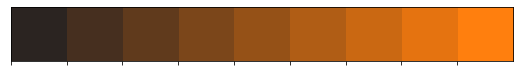

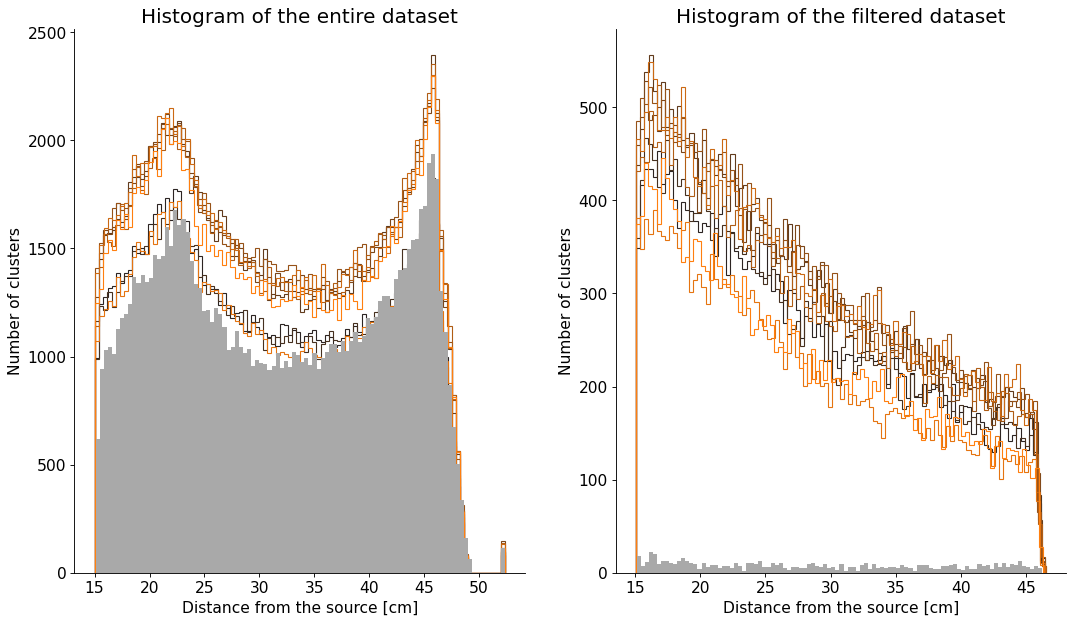

In [ ]:
#@title Comparing the cleaned and the original dataset

nbin=100
color = get_color(9, 'tab:orange')

fig, (ax) = plt.subplots(1,2, figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
ax[0].set_title('Histogram of the entire dataset', fontsize=18)
ax[1].set_title('Histogram of the filtered dataset', fontsize=18)

ax[0].hist(dataset['D[cm]'].loc[dataset['z[cm]']==0], bins=nbin, color='darkgray', zorder=5)
ax[1].hist(roi['D[cm]'].loc[roi['z[cm]']==0], bins=nbin, color='darkgray', zorder=5)

i=0
for dist in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
  ax[0].hist(dataset['D[cm]'].loc[dataset['z[cm]']==dist], bins=nbin, histtype='step', lw=1, color=color[i])
  ax[1].hist(roi['D[cm]'].loc[roi['z[cm]']==dist], bins=nbin, histtype='step', lw=1, color=color[i])
  i = i+1
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel('Distance from the source [cm]', x=0.5, ha='center', fontsize=14)

ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel('Distance from the source [cm]', x=0.5, ha='center', fontsize=14)

plt.show()

A = 1605+/-11
Absorption length: 25.37+/-0.17 cm
RMSE :  23.36402374664824


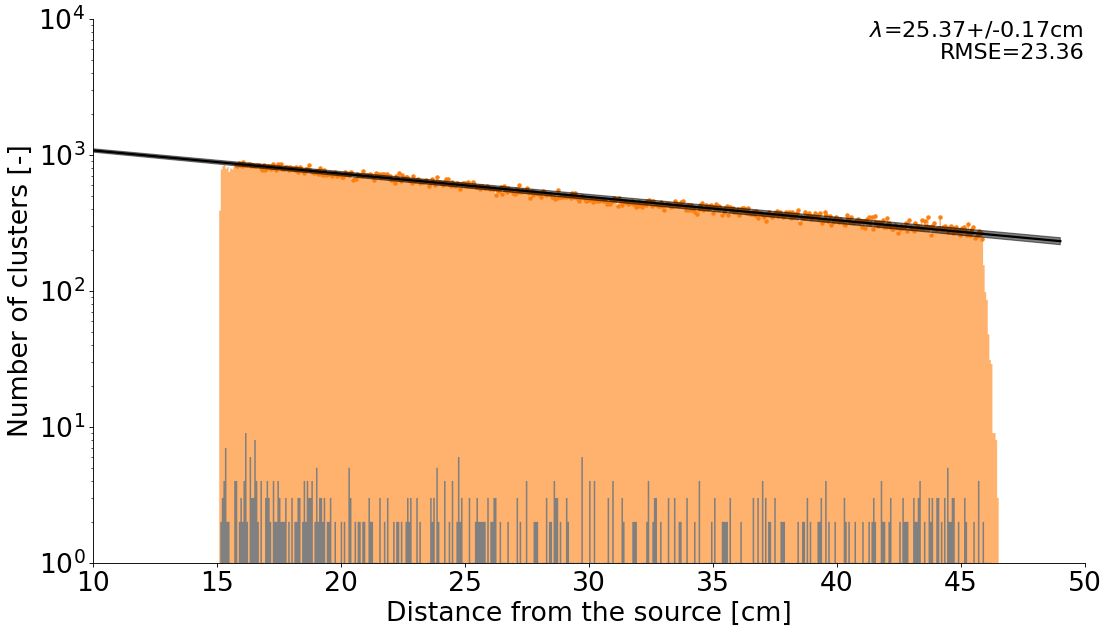

In [ ]:
#@title Absorption length for all clusters

nbins=500
border=10
fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
n, bins, patches = ax.hist(roi['D[cm]'].loc[roi['z[cm]']!=0], bins=nbin, histtype='stepfilled', lw=1, color='tab:orange', alpha=0.6)
ax.hist(roi['D[cm]'].loc[roi['z[cm]']==0], bins=nbin, histtype='stepfilled', lw=1, color='gray', zorder=5)
bin_middles = (bins[1:]+bins[:-1])/2
x=np.arange(0, 50, 1)
ax.plot(bin_middles[border:nbin-border], n[border:nbin-border], color='tab:orange', marker='.', lw=0)

popt, pcov = curve_fit(fit, bin_middles[border:nbin-border], n[border:nbin-border], p0=[10, 20])
ycalc = fit(x, *popt)
pcov = np.sqrt(np.diag(pcov))
print('A =', (ufloat(popt[0], pcov[0])))
print('Absorption length:', ufloat(popt[1], pcov[1]), 'cm')
rmse = np.sqrt(mean_squared_error(n[border:nbin-border], fit(bin_middles[border:nbin-border], *popt)))
print('RMSE : ', rmse)

bound_upper = fit(x, *(popt + 3*pcov))
bound_lower = fit(x, *(popt - 3*pcov))
ax.plot(x, ycalc, lw=2, color='k', zorder=5)
ax.fill_between(x, bound_lower, bound_upper, alpha=0.5, color='k', zorder=4)
ax.text(50, 1e4, '$\lambda$='+str(ufloat(popt[1], pcov[1]))+'cm \nRMSE='+str(round(rmse,2)), ha='right', va='top', fontsize=20)

ax.set_xlim(10,50)
ax.set_ylim(1,1e4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('Distance from the source [cm]', x=0.5, ha='center', fontsize=24)
ax.set_ylabel('Number of clusters [-]', y=0.5, ha='center', fontsize=24)

plt.semilogy()
plt.show()

## Absorption length for different apertures

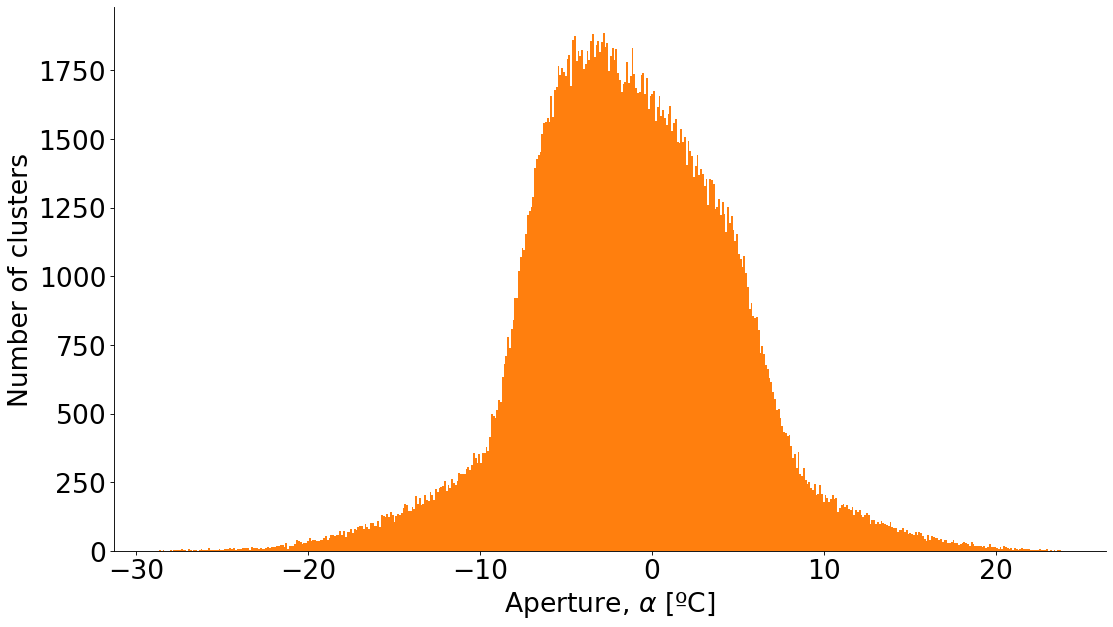

Max. alpha 28.64674977874619


In [145]:
#@title Calculating the aperture for each cluster

roi['alpha'] = np.arctan((y0-roi['yMean'])/(x0-roi['xMean']))*180/np.pi
fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 

plt.hist(roi['alpha'], bins=500, color='tab:orange')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel(r'Aperture, $\alpha$ [ºC]', x=0.5, ha='center', fontsize=24)

plt.show()
print('Max. alpha', np.max(np.abs(roi['alpha'])))

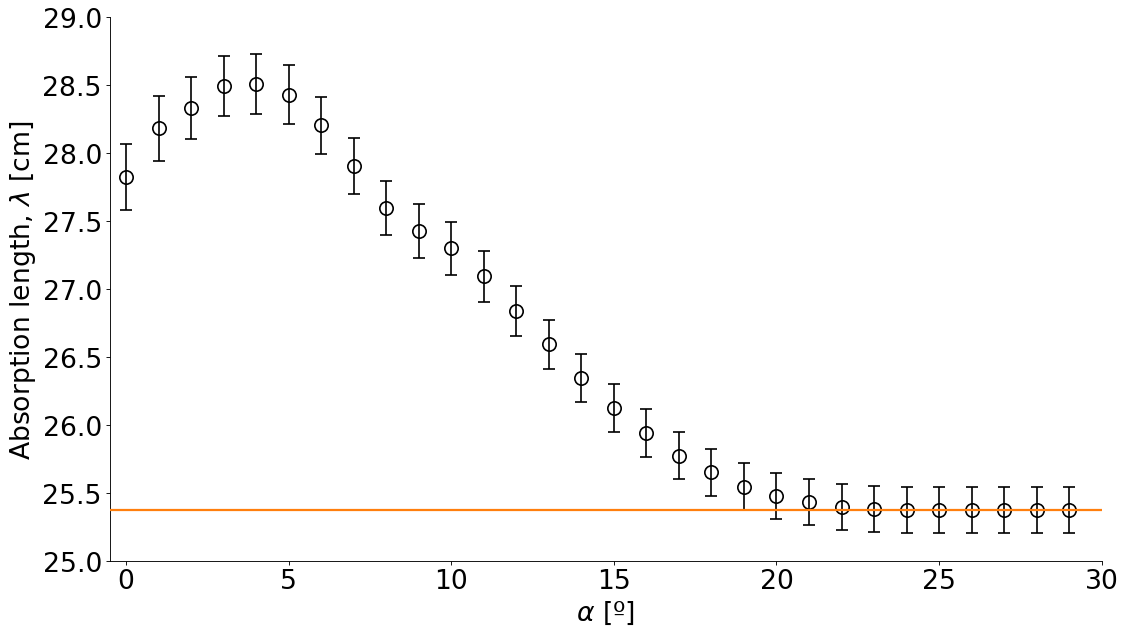

In [149]:
#@title Absorption Lengths
def calc_lambda(roi, alphas, A):
  nbin=500
  border=10
  plots = int(len(alphas)/2)
  lambdas = []
  dlambdas = []
  for alpha in alphas:
    n, bins, patches = plt.hist(roi['D[cm]'].loc[(roi['z[cm]']!=0) & (roi['alpha']<=alpha)], bins=nbin, histtype='stepfilled', lw=1, color='tab:orange', alpha=0.6)
    bin_middles = (bins[1:]+bins[:-1])/2
    x=np.arange(0, 50, 1)
    plt.close()

    popt, pcov = curve_fit(fit, bin_middles[border:nbin-border], n[border:nbin-border], p0=[A, 20])
    ycalc = fit(x, *popt)
    pcov = np.sqrt(np.diag(pcov))
    #display('-'*100)
    #print('alpha <=', alpha)
    #print('A =', (ufloat(popt[0], pcov[0])))
    #print('Absorption length:', ufloat(popt[1], pcov[1]), 'cm')
    lambdas.append(popt[1])
    dlambdas.append(pcov[1])
    rmse = np.sqrt(mean_squared_error(n[border:nbin-border], fit(bin_middles[border:nbin-border], *popt)))
    #print('RMSE : ', rmse)

  return alphas, lambdas, dlambdas

alphas, lamb, dlamb = calc_lambda(roi, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 
                                        21, 22, 23, 24, 25, 26, 27, 28, 29], 1000)

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
plt.errorbar(alphas, lamb, yerr=dlamb, color='none', marker='o', markersize=12, 
            markeredgecolor='k', markeredgewidth=1.5, ecolor='k', elinewidth=1.5, capsize=5, capthick=1.5)

plt.axhline(y=25.37, lw=2, color='tab:orange', zorder=3)
#plt.fill_between(np.arange(0,51,1), np.mean(absl)-3*np.std(absl), np.mean(absl)+3*np.std(absl), color='tab:orange', alpha=0.4, lw=0)
#plt.text(1, np.mean(absl)+0.7, '$\lambda=25.3(13)$ cm', fontsize=20, ha='left', va='bottom')
ax.set_xlim(-0.5,30)
ax.set_ylim(25,29)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Absorption length, $\lambda$ [cm]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel(r'$\alpha$ [º]', x=0.5, ha='center', fontsize=24)
plt.show()

Average absorption length: 25.3+/-1.3 cm


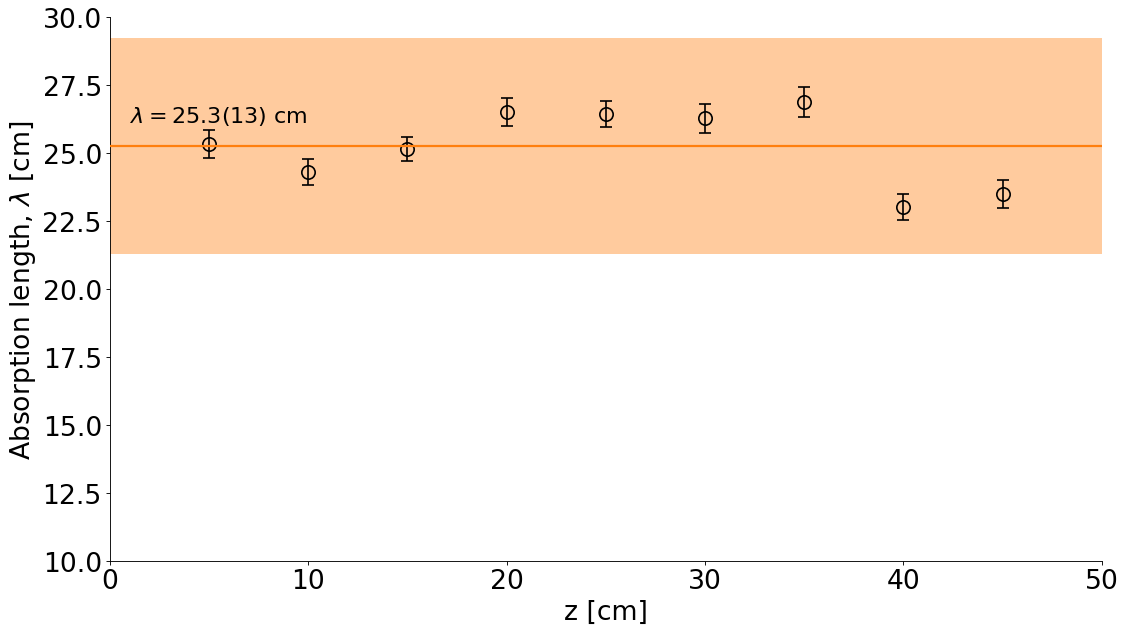

In [ ]:
#@title Average absorption length
z = [5, 10, 15, 20, 25, 30, 35, 40, 45]

print('Average absorption length:', ufloat(np.mean(absl), np.std(absl)), 'cm')

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
plt.errorbar(z, absl, yerr=dabsl, color='none', marker='o', markersize=12, 
            markeredgecolor='k', markeredgewidth=1.5, ecolor='k', elinewidth=1.5, capsize=5, capthick=1.5)
plt.axhline(y=np.mean(absl), lw=2, color='tab:orange', zorder=3)
plt.fill_between(np.arange(0,51,1), np.mean(absl)-3*np.std(absl), np.mean(absl)+3*np.std(absl), color='tab:orange', alpha=0.4, lw=0)
plt.text(1, np.mean(absl)+0.7, '$\lambda=25.3(13)$ cm', fontsize=20, ha='left', va='bottom')
ax.set_xlim(0,50)
ax.set_ylim(10,30)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Absorption length, $\lambda$ [cm]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('z [cm]', x=0.5, ha='center', fontsize=24)

plt.show()